Since diffusion-basics.ipynb became too long, starting afresh in this notebook

And trying U-net architecture again (as per Tejas' advice)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from diffusers import UNet2DModel
import matplotlib as plt

/Users/paraschopra/opt/anaconda3/envs/pyautogen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/paraschopra/opt/anaconda3/envs/pyautogen/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [2]:
import wandb
# start a new wandb run to track this script


In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [4]:
class DiffusionModel(nn.Module):
    def __init__(self, img_size, num_classes=10, class_emb_size=4):
        super().__init__()

        # The embedding layer will map the class label to a vector of size class_emb_size 
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        self.model = UNet2DModel(
            sample_size=img_size,            # the target image resolution
            in_channels=1 + class_emb_size,  # Additional input channels to accept the conditioning information (the class)
            out_channels=1,            # the number of output channels
            layers_per_block=2,        # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),  
            down_block_types=(
                "DownBlock2D",          # a regular ResNet downsampling block
                "AttnDownBlock2D",      # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",        # a ResNet upsampling block with spatial self-attention
                "AttnUpBlock2D",
                "UpBlock2D",            # a regular ResNet upsampling block
            ),
        )

    # Our forward method now takes the class labels as an additional argument
    def forward(self, x, t, class_label):
        # Shape of x:
        bs, ch, w, h = x.shape
    
        # class conditioning is right shape to add as additional input channel
        class_cond = self.class_emb(class_label).view(bs, self.class_emb.embedding_dim, 1, 1)
        class_cond = class_cond.expand(bs, self.class_emb.embedding_dim, w, h)
        # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)
    
        # Net input is now x and class cond concatenated together along dimension 1
        net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)
    
        # Feed the UNet with net_input, time step t, and return the prediction
        return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [5]:
import random
import matplotlib.pyplot as plt

def sample_image_multiple(num_samples=1):
    with torch.no_grad():
        # Generate initial pure Gaussian noise
        x = torch.randn(num_samples, 1, 28, 28).to(device)
        y = torch.randint(0, 10, (num_samples,)).to(device)  # Generate random target labels
        
        for t in range(len(alpha_bar) - 1, -1, -1):
            z = torch.randn(num_samples, 1, 28, 28).to(device) if t > 0 else 0
            alpha_t = alpha[t]
            alpha_bar_t = alpha_bar[t]
            beta_t = beta[t]
            #alpha_t_prev = alpha_bar[t - 1] if t > 0 else 1
            
            predicted_noise = model(x, torch.tensor([t]).expand(num_samples).to(device), y)
            
            x = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * predicted_noise) + torch.sqrt(beta_t) * z
        
        generated_samples = x.cpu().squeeze().numpy()
    
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    
    for i in range(num_samples):
        if num_samples == 1:
            axs.imshow(generated_samples[i], cmap="gray")
            axs.set_title(f"Digit: {y[i].item()}")
            axs.axis("off")
        else:
            axs[i].imshow(generated_samples[i], cmap="gray")
            axs[i].set_title(f"Digit: {y[i].item()}")
            axs[i].axis("off")
    
    plt.tight_layout()
    plt.show()

In [14]:
def train(epochs=100):
    loss_ema = None
    for epoch in range(epochs):
        i = 0
        for data, labels in trainloader:
            data, labels = data.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Randomly generate timesteps for each example in the batch
            t = torch.randint(0, num_steps, (data.shape[0],), device=device)
            
            # Retrieve the corresponding alpha_bar_t values for each example in the batch
            alpha_bar_t = alpha_bar[t]
            
            # Generate random noise (mean 0, sd 1) tensor with the same shape as input data
            noise = torch.randn_like(data)
            
            # Calculate the noisy data using the reparameterization trick
            noisy_data = torch.sqrt(alpha_bar_t).view(-1, 1, 1, 1) * data + torch.sqrt(1 - alpha_bar_t).view(-1, 1, 1, 1) * noise
            
            predicted_noise = model(noisy_data, t, labels)
            loss = criterion(predicted_noise, noisy_data - data)
            
            loss.backward()

            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.9 * loss_ema + 0.1 * loss.item()

            wandb.log({"latest_loss": loss.item(), "avg_running_loss": loss_ema}, step=epoch * len(trainloader) + i)
            
            optimizer.step()
            
            if (i % 50) == 0:
                print(f"Epoch [{epoch+1}/1000], i: {i}, Loss: {loss.item():.4f}, Running loss: {loss_ema}")
            
            i += 1
        
        if epoch % 5 == 0:
            sample_image_multiple(num_samples=4)

    wandb.finish()

In [6]:
num_steps = 1000
beta_start = 0.0001
beta_end = 0.02
# Generate the beta values linearly from beta_start to beta_end
beta = torch.linspace(beta_start, beta_end, num_steps).to(device)
alpha = 1 - beta
# Pre-calculate alpha_bar_t for all timesteps
alpha_bar = torch.cumprod(alpha, dim=0)

In [7]:
alpha_bar

tensor([9.9990e-01, 9.9978e-01, 9.9964e-01, 9.9948e-01, 9.9930e-01, 9.9910e-01,
        9.9888e-01, 9.9864e-01, 9.9838e-01, 9.9811e-01, 9.9781e-01, 9.9749e-01,
        9.9715e-01, 9.9679e-01, 9.9641e-01, 9.9602e-01, 9.9560e-01, 9.9516e-01,
        9.9471e-01, 9.9423e-01, 9.9374e-01, 9.9322e-01, 9.9269e-01, 9.9213e-01,
        9.9156e-01, 9.9097e-01, 9.9035e-01, 9.8972e-01, 9.8907e-01, 9.8840e-01,
        9.8771e-01, 9.8700e-01, 9.8627e-01, 9.8553e-01, 9.8476e-01, 9.8398e-01,
        9.8317e-01, 9.8235e-01, 9.8151e-01, 9.8065e-01, 9.7977e-01, 9.7887e-01,
        9.7795e-01, 9.7702e-01, 9.7606e-01, 9.7509e-01, 9.7410e-01, 9.7309e-01,
        9.7206e-01, 9.7102e-01, 9.6995e-01, 9.6887e-01, 9.6777e-01, 9.6665e-01,
        9.6551e-01, 9.6436e-01, 9.6319e-01, 9.6200e-01, 9.6079e-01, 9.5956e-01,
        9.5832e-01, 9.5706e-01, 9.5578e-01, 9.5449e-01, 9.5318e-01, 9.5185e-01,
        9.5050e-01, 9.4914e-01, 9.4776e-01, 9.4636e-01, 9.4494e-01, 9.4351e-01,
        9.4207e-01, 9.4060e-01, 9.3912e-

In [8]:
torch.sqrt(alpha_bar)

tensor([0.9999, 0.9999, 0.9998, 0.9997, 0.9997, 0.9996, 0.9994, 0.9993, 0.9992,
        0.9991, 0.9989, 0.9987, 0.9986, 0.9984, 0.9982, 0.9980, 0.9978, 0.9976,
        0.9973, 0.9971, 0.9969, 0.9966, 0.9963, 0.9961, 0.9958, 0.9955, 0.9952,
        0.9948, 0.9945, 0.9942, 0.9938, 0.9935, 0.9931, 0.9927, 0.9924, 0.9920,
        0.9916, 0.9911, 0.9907, 0.9903, 0.9898, 0.9894, 0.9889, 0.9884, 0.9880,
        0.9875, 0.9870, 0.9865, 0.9859, 0.9854, 0.9849, 0.9843, 0.9838, 0.9832,
        0.9826, 0.9820, 0.9814, 0.9808, 0.9802, 0.9796, 0.9789, 0.9783, 0.9776,
        0.9770, 0.9763, 0.9756, 0.9749, 0.9742, 0.9735, 0.9728, 0.9721, 0.9713,
        0.9706, 0.9698, 0.9691, 0.9683, 0.9675, 0.9667, 0.9659, 0.9651, 0.9643,
        0.9635, 0.9626, 0.9618, 0.9610, 0.9601, 0.9592, 0.9583, 0.9575, 0.9566,
        0.9556, 0.9547, 0.9538, 0.9529, 0.9519, 0.9510, 0.9500, 0.9491, 0.9481,
        0.9471, 0.9461, 0.9451, 0.9441, 0.9431, 0.9421, 0.9410, 0.9400, 0.9389,
        0.9379, 0.9368, 0.9358, 0.9347, 

In [9]:
torch.sqrt(1-alpha_bar)

tensor([0.0100, 0.0148, 0.0190, 0.0228, 0.0264, 0.0300, 0.0334, 0.0368, 0.0402,
        0.0435, 0.0468, 0.0501, 0.0534, 0.0566, 0.0599, 0.0631, 0.0663, 0.0695,
        0.0728, 0.0760, 0.0791, 0.0823, 0.0855, 0.0887, 0.0919, 0.0951, 0.0982,
        0.1014, 0.1045, 0.1077, 0.1109, 0.1140, 0.1172, 0.1203, 0.1234, 0.1266,
        0.1297, 0.1329, 0.1360, 0.1391, 0.1422, 0.1454, 0.1485, 0.1516, 0.1547,
        0.1578, 0.1609, 0.1640, 0.1671, 0.1702, 0.1733, 0.1764, 0.1795, 0.1826,
        0.1857, 0.1888, 0.1919, 0.1949, 0.1980, 0.2011, 0.2042, 0.2072, 0.2103,
        0.2133, 0.2164, 0.2194, 0.2225, 0.2255, 0.2286, 0.2316, 0.2346, 0.2377,
        0.2407, 0.2437, 0.2467, 0.2498, 0.2528, 0.2558, 0.2588, 0.2618, 0.2648,
        0.2678, 0.2708, 0.2737, 0.2767, 0.2797, 0.2827, 0.2856, 0.2886, 0.2916,
        0.2945, 0.2975, 0.3004, 0.3033, 0.3063, 0.3092, 0.3121, 0.3151, 0.3180,
        0.3209, 0.3238, 0.3267, 0.3296, 0.3325, 0.3354, 0.3383, 0.3412, 0.3441,
        0.3469, 0.3498, 0.3527, 0.3555, 

In [16]:
learning_rate = 2e-4
epochs=100
batch_size=128

wandb.init(
    # set the wandb project where this run will be logged
    project="diffusion-with-unet")

config = {
    "learning_rate": learning_rate,
    "epochs": epochs,
    "batch_size": batch_size,
    "num_steps":num_steps,
    "noise_schedule":"linear"
}
wandb.config.update(config)

avg_running_loss,█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
latest_loss,█▆▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▂▂▂▁▂▂▂▁▁▂▂▂
avg_running_loss,0.12473
latest_loss,0.1202


In [17]:
class RescaleTransform(object):
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, tensor):
        return (self.max_val - self.min_val) * tensor + self.min_val # convert 0-1 range to -1 to +1 range

#transform = transforms.Compose([
#    transforms.ToTensor(),
#    RescaleTransform(-1, 1)
#])

transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (1.0))]
    )

trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [18]:
model = DiffusionModel(img_size=28, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

Epoch [1/1000], i: 0, Loss: 0.9277, Running loss: 0.9276642203330994
Epoch [1/1000], i: 50, Loss: 0.1063, Running loss: 0.12370741496554599
Epoch [1/1000], i: 100, Loss: 0.0743, Running loss: 0.07662388149141575
Epoch [1/1000], i: 150, Loss: 0.0580, Running loss: 0.06244897400107166
Epoch [1/1000], i: 200, Loss: 0.0560, Running loss: 0.0554244230289984
Epoch [1/1000], i: 250, Loss: 0.0498, Running loss: 0.05075375477805815
Epoch [1/1000], i: 300, Loss: 0.0509, Running loss: 0.048486490721193765
Epoch [1/1000], i: 350, Loss: 0.0461, Running loss: 0.045956664015922334
Epoch [1/1000], i: 400, Loss: 0.0485, Running loss: 0.04624334194098545
Epoch [1/1000], i: 450, Loss: 0.0414, Running loss: 0.04408469159705012


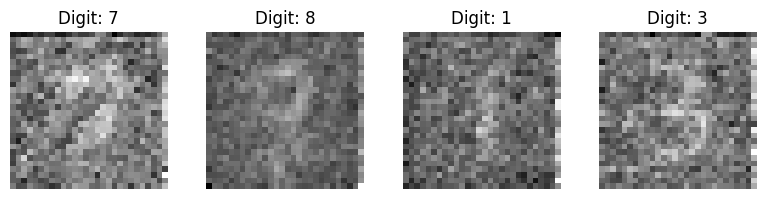

Epoch [2/1000], i: 0, Loss: 0.0464, Running loss: 0.04425639763983014
Epoch [2/1000], i: 50, Loss: 0.0442, Running loss: 0.044093252144754694
Epoch [2/1000], i: 100, Loss: 0.0393, Running loss: 0.04277958755628796
Epoch [2/1000], i: 150, Loss: 0.0461, Running loss: 0.0428136428230388
Epoch [2/1000], i: 200, Loss: 0.0436, Running loss: 0.04179019315163255
Epoch [2/1000], i: 250, Loss: 0.0401, Running loss: 0.04165210072281668
Epoch [2/1000], i: 300, Loss: 0.0417, Running loss: 0.04185285243118931
Epoch [2/1000], i: 350, Loss: 0.0351, Running loss: 0.0397018810046063
Epoch [2/1000], i: 400, Loss: 0.0428, Running loss: 0.04109373107284993
Epoch [2/1000], i: 450, Loss: 0.0406, Running loss: 0.04117118336560254
Epoch [3/1000], i: 0, Loss: 0.0340, Running loss: 0.039412026826804156
Epoch [3/1000], i: 50, Loss: 0.0376, Running loss: 0.04009625970413566
Epoch [3/1000], i: 100, Loss: 0.0405, Running loss: 0.0394774660375641
Epoch [3/1000], i: 150, Loss: 0.0371, Running loss: 0.04019775143858276

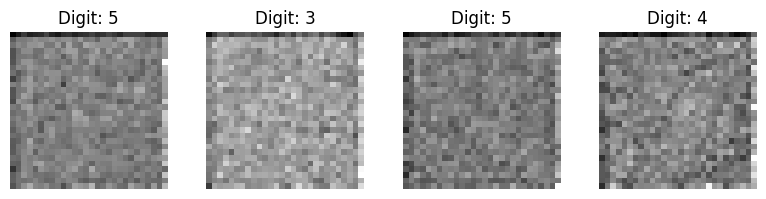

Epoch [7/1000], i: 0, Loss: 0.0377, Running loss: 0.03745057309262968
Epoch [7/1000], i: 50, Loss: 0.0382, Running loss: 0.03739207557299391


KeyboardInterrupt: 

In [19]:
train(epochs)

In [33]:
wandb.finish()

avg_running_loss,▁█▄▄▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
latest_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_running_loss,0.03641
latest_loss,0.03718
